# Process
In this notebook, we will do a first analysis of properties distribution on the data so that we can use it later on. Code segments taken from <a href = "https://github.com/rahmanidashti/FairBook"> Fairbook </a>.

## A. Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from analyze_data import users_and_items, user_country_distribution, calculate_group_characteristics
from plots import plot_country_distribution, plot_profile_size_vs_USA_ratio, plot_group_characteristics
from split_users import split
from collections import Counter

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [16]:
item_col = "ISBN" # the item column
user_col = "User-ID"
my_seed = 0 # random_seed
split_country_by = "ratio_USA"
top_fraction_users = 0.2 # the limit for a user to be considered 'High' preference

In [3]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

## C. Read files

In [4]:
processed_file_location = "data/processed/"

ratings_file = processed_file_location + "fairbook_ratings_mapped.csv" # the ratings file
ratings_with_properties = pd.read_csv(ratings_file,  header=0, low_memory=False).fillna("")

In [5]:
ratings_with_properties.head()

,User-ID,ISBN,Book-Rating,title,author,year,publisher,alt_title,alt_author,correct_author,...,QID,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
0,276847,0,10,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Stein der Weisen,Joanne K. Rowling,Joanne K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling
1,276847,1,10,Harry Potter und die Kammer des Schreckens,Joanne K. Rowling,2000.0,Carlsen Verlag GmbH,Harry Potter und die Kammer des Schreckens (Ha...,J.K. Rowling,J.K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling
2,276847,2,10,Harry Potter und der Gefangene von Azkaban,J. K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Gefangene von Askaban (Ha...,J.K. Rowling,J.K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling
3,276847,3,10,Harry Potter Und Der Feuerkelch,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Feuerkelch (Harry Potter 4),J.K. Rowling,J.K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling
4,276964,4,10,The Terminal Man,Michael Crichton,1988.0,Ballantine Books,The Terminal Man,Michael Crichton,Michael Crichton,...,Q172140,,United States of America,,deism,male,,1942.0,2008.0,Michael Crichton


##  D. Country analysis

First, we are replacing any empty country with "unknown" and simplifying country names.

In [6]:
df = ratings_with_properties.copy()
df["country"] = df["country"].apply(lambda x: "unknown" if x=="" else x)
# simplify country names
df["country"] = df["country"].apply(lambda x: "USA" if x=="United States of America" else x)
df["country"] = df["country"].apply(lambda x: "UK" if x=="United Kingdom" else x)
df["country"] = df["country"].apply(lambda x: "Ireland" if x=="Republic of Ireland" else x)

In [7]:
most_common_5 = [x[0] for x in Counter(df.country).most_common()[:5]] # most common countries for this dataset

In [8]:
df["country"] = df["country"].apply(lambda x: "other" if x not in most_common_5 else x)

Save this version of the dataset!

In [9]:
df.to_csv(processed_file_location  +"/final_fairbook_ratings.csv", index=False)

### D1. Define and calculate country odds

First, we will keep only the relevant columns.

In [10]:
df_country = df[[user_col, item_col, "Book-Rating", "country"]]

In [11]:
df_country.head()

,User-ID,ISBN,Book-Rating,country
0,276847,0,10,UK
1,276847,1,10,UK
2,276847,2,10,UK
3,276847,3,10,UK
4,276964,4,10,USA


Then, we call a function to calculate the country distribution per user.

The way we do it is by calculating: <br>
nUSA = number of books in profile written by USA citizens<br>
tb = number of books in profile <br>

<u>So for every user u, we define <i>ratio_USA</i> as:</u>

ratio_USA(u) = nUSA(u)/tb(u)

<b>Basically the percentage of books written by USA citizens</b>

In [12]:
user_country_dist, num_users = user_country_distribution(df_country, user_col, split_country_by,  prnt = True)

Mean ratio_USAs per user: 0.73886
Standard deviation of ratio_USAs per user: 0.21338
Min ratio_USAs per user: 0.0
Max ratio_USAs per user: 1.0


### D2. Plot country distribution among users

First, we will plot the sorted ratios.

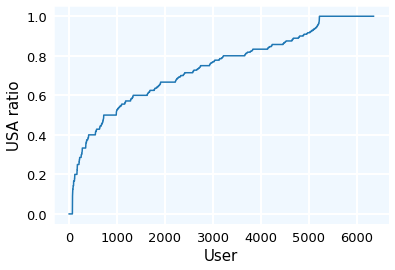

In [13]:
plot_country_distribution(user_country_dist.ratio_USA.values)

Then, we will plot if there is a relation between user profile size and ratio of books written by USA citizens in profile.

R-value: 0.022143364334910338


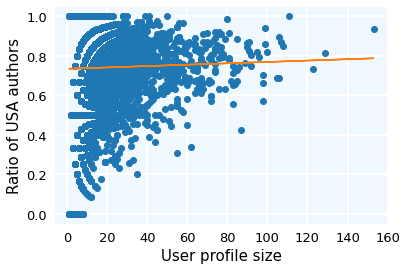

In [14]:
plot_profile_size_vs_USA_ratio(user_country_dist.ratio_USA.values,user_country_dist.num_total.values)

### D3. Divide users based on country distribution

First, we will divide the users into low USA preference, medium USA preference, and high USA preference.

In [17]:
low_Up, med_Up, high_Up = split(user_country_dist, top_fraction_users)

Then, we will calculate the characteristics of each group.

In [18]:
low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users = calculate_group_characteristics(low_Up, med_Up, high_Up, count_column = "num_total", way = "country")

low USA Oriented: 11.31
mid USA Oriented: 15.76
USA Oriented: 9.36


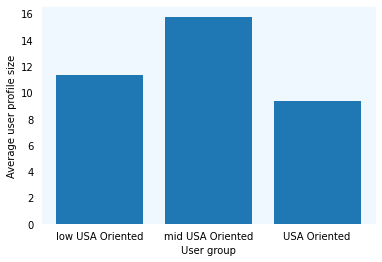

In [19]:
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size,analysis_type = "country")

low USA Oriented: 1270
mid USA Oriented: 3813
USA Oriented: 1271


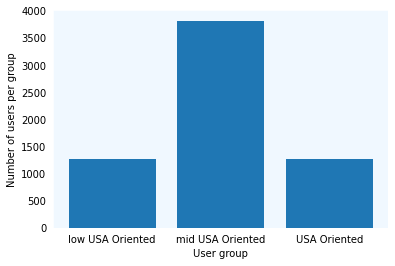

In [20]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users,analysis_type = "country", way = "number of users")

low USA Oriented: 0.41
mid USA Oriented: 0.76
USA Oriented: 0.99


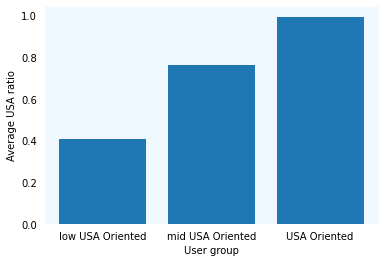

In [21]:
low_Up_ave = low_Up.ratio_USA.mean()
med_Up_ave = med_Up.ratio_USA.mean()
high_Up_ave = high_Up.ratio_USA.mean()
plot_group_characteristics(low_Up_ave, med_Up_ave, high_Up_ave,analysis_type = "country", way = "specific metric")

## E. Save processed data

In [23]:
low_Up.to_csv(processed_file_location +"/low_users_USA.csv")
med_Up.to_csv(processed_file_location  + "/med_users_USA.csv")
high_Up.to_csv(processed_file_location  + "/high_users_USA.csv")